In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, BisectingKMeans

import torch
from torch.utils.data import DataLoader, Subset

import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# get dataset
# transform from 1 channel to 3 channel image for model that expects 3 channel input
trans = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
dataset = datasets.MNIST(root='dataset/', train=True, transform=trans, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 73513117.64it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74089109.37it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20310033.59it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16171925.95it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

In [4]:
# get data subsets
# get indicies of 5, 6, 8, 9
# similar shapes, more difficult to group into clusters?
idx5 = [i for i, (_, label) in enumerate(dataset) if label == 5]
idx6 = [i for i, (_, label) in enumerate(dataset) if label == 6]
idx8 = [i for i, (_, label) in enumerate(dataset) if label == 8]
idx9 = [i for i, (_, label) in enumerate(dataset) if label == 9]

# create dataloaders
# data for training
five_loader = DataLoader(dataset=Subset(dataset, idx5[:-100]), batch_size=BATCH_SIZE, shuffle=True)
six_loader = DataLoader(dataset=Subset(dataset, idx6[:-100]), batch_size=BATCH_SIZE, shuffle=True)
eight_loader = DataLoader(dataset=Subset(dataset, idx8[:-100]), batch_size=BATCH_SIZE, shuffle=True)
nine_loader = DataLoader(dataset=Subset(dataset, idx9[:-100]), batch_size=BATCH_SIZE, shuffle=True)

# data to cluster
idx5689 = np.hstack([idx5[-100:], idx6[-100:], idx8[-100:], idx9[-100:]])
print(len(idx5689))
test5689_loader = DataLoader(dataset=Subset(dataset, idx5689), batch_size=BATCH_SIZE, shuffle=False)

400


In [5]:
# model pretrained with default weights
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights).to(DEVICE)
model.eval()

# get expected preprocessing steps
preprocessing = weights.transforms(antialias=True)
preprocessing

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 54.2MB/s]


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
# choose last layer of model for feature extraction
return_nodes = {'flatten': 'flatten'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

In [7]:
# extract features from data
imgfeats = []
imglabels = []
for i, (imgs, labels) in enumerate(test5689_loader):
    print('.', end='')
    imgs = imgs.to(DEVICE)
    # preprocess images
    model_input = preprocessing(imgs)
    
    # extract the features
    with torch.no_grad():
        # dict of extracted features
        features = feature_extractor(model_input)
    # get last feature
    feat_array = features['flatten'].cpu().detach().numpy()
    imgfeats.append(feat_array)
    imglabels.append(labels)
    

.......

In [8]:
# put extracted features into array
allimgfeats = np.vstack(imgfeats)
alllabels = np.hstack(imglabels)
print(allimgfeats.shape, alllabels.shape)

(400, 1280) (400,)


In [9]:
# only keep features that aren't all zero
print(f'num non-zero feats: {np.sum(np.sum(allimgfeats, axis=0) > 0)}')
nonzerofeats = allimgfeats[:, np.sum(allimgfeats, axis=0) > 0]
print(f'shape of non zero feats: {nonzerofeats.shape}')

num non-zero feats: 371
shape of non zero feats: (400, 371)


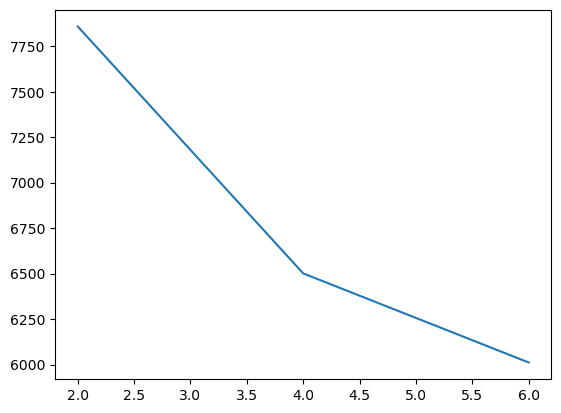

In [10]:
# cluster on non-zero feat, check num of clusters
ssds = []
ns = []
for n in range(2, 8, 2):
    km = KMeans(n_clusters=n, n_init=5, init='k-means++')
    kmclust = km.fit_predict(nonzerofeats)
    ssds.append(km.inertia_)
    ns.append(n)
    
plt.plot(ns, ssds)

In [11]:
# cluster with k-means, 4 clusters
km = KMeans(n_clusters=4, n_init=5, init='k-means++')
kmclust = km.fit_predict(nonzerofeats)

In [12]:
# put clusters and labels in df
resdf = pd.DataFrame({'labels': alllabels, 'km': kmclust})

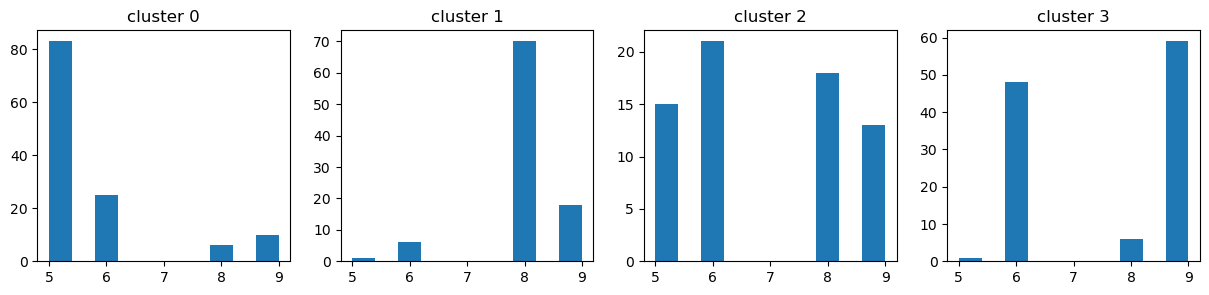

In [13]:
# distribution of each label in clusters
fig, ax = plt.subplots(1,4, figsize=(15,3))
axs = ax.ravel()
for i in range(4):
    axs[i].hist(resdf.loc[resdf['km']==i, 'labels'])
    axs[i].set_title(f'cluster {i}')